# Processamento de Linguagem Natural (NLP)

Professor: Arlindo Galvão

Data: 09/09/2024

## Cronograma

* Implemente diversos tipos de atenção

### **Implementando RNN Seq2Seq sem atenção**

In [727]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Teremos 4 classes principais:**
- **Tokenizer:** mapeia nosso input textual para o input do modelo;
- **Encoder:** realiza o encoding do input;
- **Decoder:** realiza a decodificação a partir do hidden state anterior (com a possibilidade de attention);
- **Seq2seq:** encapsula nosso Encoder e nosso Decoder, e transforma do espaço latente para o token id.

**Tokenizer:** Aqui que iremos trabalhar com nossos dados de entrada. Todos os tratamentos iremos fazer por meio desta classe.

In [728]:
class Tokenizer():
    def __init__(self):
        self.tokens_special = ["<sos>", "<eos>", "<oov>",]
        self.vocab_input = self.tokens_special[:]
        self.vocab_output = self.tokens_special[:]
        self.len_vocab_input = len(self.vocab_input)
        self.len_vocab_output = len(self.vocab_output)

        self.SOS_ID = self.tokens_special.index("<sos>") # start of sentence
        self.EOS_ID = self.tokens_special.index("<eos>") # end of sentence
        self.OOV_ID = self.tokens_special.index("<oov>") # out of vocabulary


    def add_input_vocab(self, tokens):
        # Caso passe uma frase, o split tokenizará por espaços
        if type(tokens) == str:
            tokens = tokens.split()
        for token in tokens:
            if token not in self.vocab_input:
                self.vocab_input.append(token)
        self.len_vocab_input = len(self.vocab_input)


    def add_output_vocab(self, tokens):
        # Caso passe uma frase, o split tokenizará por espaços
        if type(tokens) == str:
            tokens = tokens.split()
        for token in tokens:
            if token not in self.vocab_output:
                self.vocab_output.append(token)
        self.len_vocab_output = len(self.vocab_output)


    def tokens2inputs_id(self, tokens):
        # Caso passe uma frase, o split tokenizará por espaços
        if type(tokens) == str:
            tokens = tokens.split()

        inputs_id = [self.SOS_ID]

        for token in tokens:
            if token in self.vocab_input:
                inputs_id.append(self.vocab_input.index(token))
            else:
                inputs_id.append(self.OOV_ID)
        return torch.tensor(inputs_id)


    def tokens2outputs_id(self, tokens):
        outputs_id = []
        for token in tokens:
            if token in self.vocab_output:
                outputs_id.append(self.vocab_output.index(token))
            else:
                outputs_id.append(self.OOV_ID)
        outputs_id.append(self.EOS_ID)
        return torch.tensor(outputs_id)


    def outputs_id2text(self, outputs_id):
        if type(outputs_id) == int:
            outputs_id = [outputs_id]
        text = ""
        for id in outputs_id:
            text += self.vocab_output[id]
        return text

**Encoder:** Aqui que ocorrerá o processamento do nosso input.

In [729]:
class Encoder(nn.Module):
    def __init__(self, input_vocab_size, emb_dim, hidden_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_vocab_size, emb_dim)
        self.rnn = nn.RNN(emb_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

**Decoder:** A partir das representações geradas pelo Encoder, nós iremos gerar nosso output utilizando esta classe.

> OBS: Ao utilizar esta classe com use_attention=True, estamos concatenando o attention ao embedding do token, e não ao hidden state.

In [730]:
class Decoder(nn.Module):
    def __init__(self, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, use_attention=False):
        super(Decoder, self).__init__()
        self.output_vocab_size = output_vocab_size
        self.embedding = nn.Embedding(output_vocab_size, emb_dim)
        self.use_attention = use_attention
        if self.use_attention:
            self.rnn = nn.RNN(emb_dim + hidden_dim, hidden_dim, n_layers, dropout=dropout)
        else:
            self.rnn = nn.RNN(emb_dim, hidden_dim, n_layers, dropout=dropout)

        self.dropout = nn.Dropout(dropout)


    def forward(self, input, hidden, attention=None):
        embedded = self.dropout(self.embedding(input))
        if self.use_attention:
            embedded = torch.cat((embedded, attention), dim=1)

        output, hidden = self.rnn(embedded, hidden)

        return output, hidden

**Seq2Seq:** Esta classe vai encapsular nosso Encoder e nosso Decoder, realizando o fluxo do nosso modelo. Também é nela que ocorrerá a linear + softmax para obter a distribuição de probabilidade de tokens.

In [731]:
class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)


    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None):
        if decoder_hidden_state is None:
            encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)
        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state)
        output = self.fc_out(output)
        output_distribution = F.softmax(output, dim=1)
        return output_distribution, hidden

Agora, vamos configurar e utilizar nosso modelo

In [732]:
EMB_DIM = 16
HIDDEN_DIM = 16
N_LAYERS = 1
DROPOUT = 0.0
MAX_STEPS = 10
tokenizer = Tokenizer()
inputs = ["a", "b", "c", "d"]
outputs = ["1", "2", "3", "4"]
tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

In [733]:
model = Seq2Seq(tokenizer.len_vocab_input, tokenizer.len_vocab_output, EMB_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
# Vamos printar nossa arquitetura, veremos que possui um encoder, um decoder e uma linear ao final
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7, 16)
    (rnn): RNN(16, 16)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(7, 16)
    (rnn): RNN(16, 16)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (fc_out): Linear(in_features=16, out_features=7, bias=True)
)


In [734]:
print(f"len(tokenizer.tokens_special): {len(tokenizer.tokens_special)}")
print(f"tokenizer.len_vocab_input: {tokenizer.len_vocab_input}")

len(tokenizer.tokens_special): 3
tokenizer.len_vocab_input: 7


In [735]:
input = "a b c d"
enc_inp = tokenizer.tokens2inputs_id(input)
hidden_state = None
token_id = torch.tensor([tokenizer.SOS_ID])
outputs_ids = []

for i in range(MAX_STEPS):
    output_distribution, hidden_state = model(enc_inp, token_id, hidden_state)
    token_id = torch.argmax(output_distribution, dim=1)  # shape = (1, 1)
    outputs_ids.append(token_id.item())
    if token_id.item() == tokenizer.EOS_ID:
        break

print(f"Entrada: {input}")
print(f"Saída: {tokenizer.outputs_id2text(outputs_ids)}")

Entrada: a b c d
Saída: 3333333333


Como nosso modelo ainda não foi treinado, é esperado que sua saída seja aleatória. Como não removemos nenhum token especial, também é possível que sua saída possua tokens especiais (como o token \<sos\> em posições além do começo da sentença).

#### **IMPLEMENTANDO O TREINAMENTO**

Abaixo está o código que realiza o treinamento do modelo. Neste exemplo, estamos mapeando modelo para traduzir cada letra para seu correspondente numérico (a:1, b:2, c:3, d:4, e:5)


Ex.
> Input: ["a", "b", "c", "d", "e"]<br>
> Output: "1 2 3 4 5"

In [736]:
# Instanciando o Tokenizer
tokenizer = Tokenizer()

# Adiciona as letras ao vocabulário do Tokenizer
inputs = ["a", "b", "c", "d", "e"]
outputs = [str(i+1) for i, _ in enumerate(inputs)] # Mapeando letras para números como strings

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

def get_random_sample():
    num_char_input = np.random.randint(1,4) # vamos escolher aleatoriamente entre 1 e 3 char para input (pode ser a, ab, abc)
    sampled_indices = np.random.randint(len(tokenizer.tokens_special), tokenizer.len_vocab_input, num_char_input) # vamos escolher nossos caracteres aleatoriamente, mas sem escolher tokens especiais
    sampled_inputs = [tokenizer.vocab_input[i] for i in sampled_indices]
    sampled_outputs = [tokenizer.vocab_output[i] for i in sampled_indices]
    return sampled_inputs, sampled_outputs  # Repare que o join do input nao tem espaço e o do output tem, pois vamos querer que ele gere também os espaços.

In [737]:
# Definir parâmetros
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000

# Instanciar o modelo
model = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

In [738]:
print(f"len(tokenizer.tokens_special): {len(tokenizer.tokens_special)}")
print(f"tokenizer.len_vocab_input: {tokenizer.len_vocab_input}")

len(tokenizer.tokens_special): 3
tokenizer.len_vocab_input: 8


In [739]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Função de treino
def train(model, tokenizer, criterion, optimizer, num_steps):
    history = {'total_steps': 0, 'loss': []}
    model.train()

    for step in range(num_steps):
        optimizer.zero_grad()

        # Exemplo de entrada e saída
        input_text, output_text = get_random_sample()

        # Converte o texto de entrada e saída para IDs
        inputs_id = tokenizer.tokens2inputs_id(input_text)
        output_target_id = tokenizer.tokens2outputs_id(output_text)
        input_id_decoder = torch.tensor([tokenizer.SOS_ID])

        # Forward pass
        loss = 0
        decoder_hidden_state = None
        for target_id in output_target_id:
            output_distribution, decoder_hidden_state = model(inputs_id_encoder=inputs_id,
                                                              input_id_decoder=input_id_decoder,
                                                              decoder_hidden_state=decoder_hidden_state)

            result_tensor = torch.zeros(tokenizer.len_vocab_output, dtype=torch.float)
            result_tensor[target_id] = 1

            # Calcula a perda, Cross Entropy entre predições e targets (precisamos do unsqueeze para adicionar a dimensão do batch no nosso result_tensor)
            loss += criterion(output_distribution, result_tensor.unsqueeze(0))

            # O próximo input do decoder será o token gerado pelo decoder atual
            input_id_decoder = torch.argmax(output_distribution, dim=1)

        # Salvando o historico de informações sobre o treinamento
        history['loss'].append(loss.item())
        history['total_steps'] += 1

        # Backpropagation
        loss.backward()
        optimizer.step()

        if step % 250 == 0:
            print(f'Epoch {step}/{num_steps}, Loss: {loss.item():.4f}')
    return history

# Treinar o modelo
history = train(model, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 8.2731
Epoch 250/5000, Loss: 2.9853
Epoch 500/5000, Loss: 3.3736
Epoch 750/5000, Loss: 4.6648
Epoch 1000/5000, Loss: 6.6552
Epoch 1250/5000, Loss: 4.7103
Epoch 1500/5000, Loss: 4.1523
Epoch 1750/5000, Loss: 3.8757
Epoch 2000/5000, Loss: 6.8482
Epoch 2250/5000, Loss: 2.5588
Epoch 2500/5000, Loss: 6.1209
Epoch 2750/5000, Loss: 3.8406
Epoch 3000/5000, Loss: 3.8501
Epoch 3250/5000, Loss: 2.5500
Epoch 3500/5000, Loss: 2.5528
Epoch 3750/5000, Loss: 6.0752
Epoch 4000/5000, Loss: 3.8665
Epoch 4250/5000, Loss: 3.8326
Epoch 4500/5000, Loss: 2.5492
Epoch 4750/5000, Loss: 3.8338


In [740]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    # Vamos fazer uma média para tentar lidar melhor com outliers (loss muito alta em meio à losses baixar ou vice-versa)
    mean_steps = 20
    mean_loss_n_steps = [sum(history['loss'][i:i+mean_steps])/mean_steps for i in range(0,history['total_steps'],mean_steps)]
    plt.plot(list(range(0,history['total_steps'],mean_steps)), mean_loss_n_steps)

    plt.title('Loss Curve')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

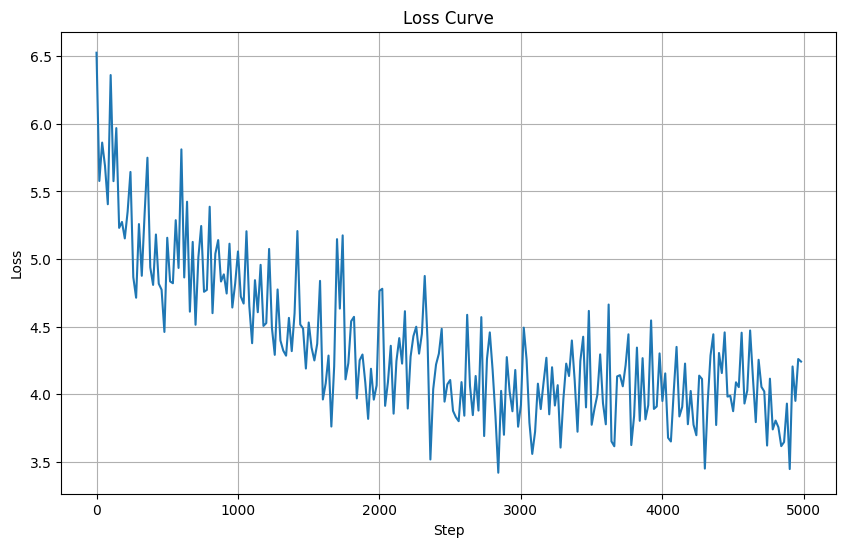

In [741]:
plot_loss(history)

Testando com inputs:

In [742]:
input = ["a", "c"]
enc_inp = tokenizer.tokens2inputs_id(input)
hidden_state = None
token_id = torch.tensor([tokenizer.SOS_ID])
outputs_ids = []

for i in range(MAX_STEPS):
    output_distribution, hidden_state = model(enc_inp, token_id, hidden_state)
    token_id = torch.argmax(output_distribution, dim=1)  # shape = (1, 1)
    outputs_ids.append(token_id.item())
    if token_id.item() == tokenizer.EOS_ID:
        break

print(f"Entrada: {' - '.join(input)}")
print(f"Saída: {' - '.join([tokenizer.outputs_id2text(outputs_ids[i]) for i in range(len(outputs_ids))])}")

Entrada: a - c
Saída: 1 - 3 - <eos>


In [743]:
'''def inferencia(input):
    enc_inp = tokenizer.tokens2inputs_id(input)
    hidden_state = None
    token_id = torch.tensor([tokenizer.SOS_ID])
    outputs_ids = []

    for i in range(MAX_STEPS):
        output_distribution, hidden_state = model(enc_inp, token_id, hidden_state)
        token_id = torch.argmax(output_distribution, dim=1)  # shape = (1,)
        outputs_ids.append(token_id.item())
        if token_id.item() == tokenizer.EOS_ID:
            break

    print(f"Entrada: {' - '.join(input)}")
    print(f"Saída: {' - '.join([tokenizer.outputs_id2text(outputs_ids[i]) for i in range(len(outputs_ids))])}")'''


def inferencia(input_tokens):
    enc_inp = tokenizer.tokens2inputs_id(input_tokens)
    hidden_state = None
    token_id = torch.tensor([tokenizer.SOS_ID])
    outputs_ids = []

    for i in range(MAX_STEPS):
        output_distribution, hidden_state = model(enc_inp, token_id, hidden_state)
        token_id = torch.argmax(output_distribution, dim=1)  # shape = (1,)
        outputs_ids.append(token_id.item())
        if token_id.item() == tokenizer.EOS_ID:
            break

    input_tokens_display = input_tokens  # tokens de entrada
    output_tokens_display = [tokenizer.outputs_id2text(id) for id in outputs_ids]  # tokens de saída

    print(f"Entrada: {' - '.join(input_tokens_display)}")
    print(f"Saída: {' - '.join(output_tokens_display)}")

    # matriz de atenção com pesos uniformes
    attention_matrix = np.ones((len(output_tokens_display), len(input_tokens_display))) / len(input_tokens_display)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention_matrix, annot=True, cmap='Blues',
                xticklabels=input_tokens_display, yticklabels=output_tokens_display)
    plt.xlabel('Tokens de Entrada')
    plt.ylabel('Tokens de Saída')
    plt.title('Mapa de Atenção com Pesos Uniformes')
    plt.show()

Parece que nosso modelo aprendeu algo :)

#### **Teste!**
Brinque com os parâmetros, dados de input e output, e teste o modelo. Entenda o que está acontecendo.

Exemplo: Como ele se comportaria caso tentassemos fazer com todo o alfabeto? E se mudassemos a quantidade máxima de tokens que o encoder é treinado?

In [744]:
tokenizer = Tokenizer()

inputs = [
"a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
"n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"
]
outputs = [str(i+1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
def get_random_sample():
     num_char_input = np.random.randint(1,4)
     sampled_indices = np.random.randint(len(tokenizer.tokens_special), tokenizer.len_vocab_input, num_char_input)
     sampled_inputs = [tokenizer.vocab_input[i] for i in sampled_indices]
     sampled_outputs = [tokenizer.vocab_output[i] for i in sampled_indices]
     return sampled_inputs, sampled_outputs

In [745]:
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000
MAX_STEPS = 2

model = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

In [746]:
history = train(model, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 13.4626
Epoch 250/5000, Loss: 6.7213
Epoch 500/5000, Loss: 6.7331
Epoch 750/5000, Loss: 10.0855
Epoch 1000/5000, Loss: 10.1202
Epoch 1250/5000, Loss: 13.4692
Epoch 1500/5000, Loss: 10.0840
Epoch 1750/5000, Loss: 6.7380
Epoch 2000/5000, Loss: 13.4422
Epoch 2250/5000, Loss: 13.4752
Epoch 2500/5000, Loss: 10.0912
Epoch 2750/5000, Loss: 13.4453
Epoch 3000/5000, Loss: 10.0873
Epoch 3250/5000, Loss: 10.0821
Epoch 3500/5000, Loss: 13.4385
Epoch 3750/5000, Loss: 6.7396
Epoch 4000/5000, Loss: 6.7349
Epoch 4250/5000, Loss: 6.7378
Epoch 4500/5000, Loss: 6.7338
Epoch 4750/5000, Loss: 13.4571


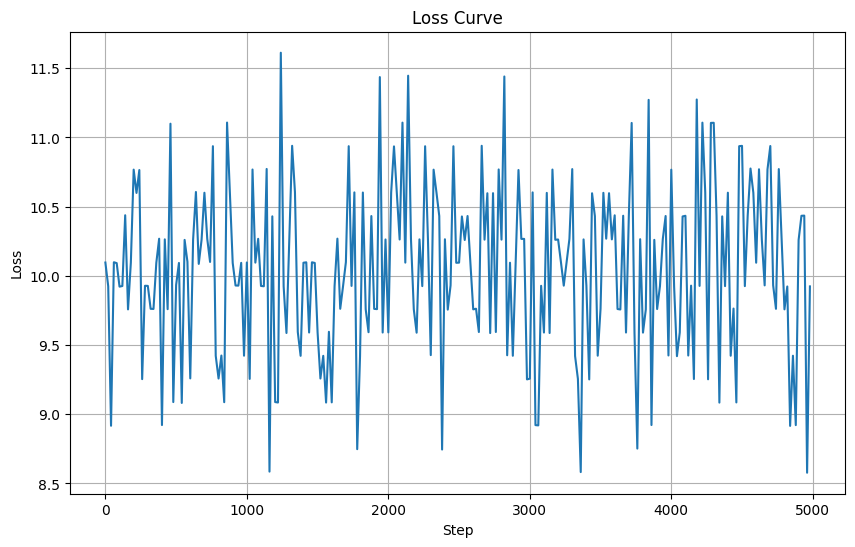

In [747]:
plot_loss(history)

---

## **ATIVIDADE**

#### **INSTRUÇÕES**

- **FOQUE EM ALTERAR APENAS A CLASSE Seq2Seq.** Caso necessário, faça alterações mínimas nas outras partes do código e documente a motivação. A ideia não é reestruturar o código, mas complementá-lo. <br><br>
- **DOCUMENTE SEU PASSO A PASSO POR MEIO DE CÉLULAS DE TEXTO.** Não utilize de grandes comentários no seu código. Utilize das ferramentas do markdown para fazer comentários, destacar, colar imagens, etc. para documentar seus avanços.<br><br>
- **NÃO EXCLUA OS OUTPUTS.** Ao entregar este notebook, não exclua o output final das células, mantenha os resultados, loss, gráficos e o que julgar necessário para entendimento do seu progresso.<br><br>
- **É PERMITIDO O USO DE LLM (ex: ChatGPT).** Documente seus prompts e como o modelo te ajudou (substitua grandes partes por placeholders na documentação, por exemplo, caso tenha colado a classe Seq2Seq, na documentação escreva "Prompt: por favor, me ajude a entender a seguinte classe: [Classe Seq2Seq]"). Cite como o LLM te ajudou em textos, não apenas colando a resposta por ele (ex: Com este prompt, o LLM me ajudou a entender ... e gerar a parte do código referente à ..., mas com erro em ...).

**Documente aqui quais LLMs foram utiliazdos:** (ex: ChatGPT)<br>
1 -

##### **A partir das classes estabelecidas e do código de treinamento, modifique a classe Seq2Seq para responder as questões seguintes:**

#### **Questão 1**
Altere a classe Seq2Seq para implementar uma attention através da média dos hidden states do encoder (semelhante à gerar um attention score igual à todos os hidden states do encoder). Mantenha a concatenação entre o attention output e o embedding como na classe Decoder originalmente implementada. Após isso, treine dois o modelo com o objetivo de traduzir cada letra para seu correspondente numérico:
- Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).

- Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)

- Após treinado, faça uma inferência condizente com o treinamento e plote o mapa de atenção para cada um dos modelos treinados.

In [754]:
# Modifique a classe abaixo
class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, use_attention=True)
        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)
        self.encoder_hidden_states = None

    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None):
        if decoder_hidden_state is None:
            self.encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)

        # calcula avg attention dos hidden states do encoder
        self.attention = self.encoder_hidden_states.mean(dim=0).unsqueeze(0) # shape = (1, hidden_dim)

        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state, attention=self.attention)
        output = self.fc_out(output)

        output_distribution = F.softmax(output, dim=1)
        #token_id = torch.argmax(output_distribution, dim=1)

        return output_distribution, hidden

##### Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)

In [755]:
# Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).
tokenizer = Tokenizer()

inputs = [
"a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
"n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"
]
outputs = [str(i+1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
print(f"len(tokenizer.tokens_special): {len(tokenizer.tokens_special)}")
print(f"tokenizer.len_vocab_input: {tokenizer.len_vocab_input}")

len(tokenizer.tokens_special): 3
tokenizer.len_vocab_input: 29


In [756]:
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000
MAX_STEPS = 2

model = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

In [751]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = train(model, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 13.4825
Epoch 250/5000, Loss: 12.5976
Epoch 500/5000, Loss: 5.7624
Epoch 750/5000, Loss: 9.1799
Epoch 1000/5000, Loss: 5.7985
Epoch 1250/5000, Loss: 12.4755
Epoch 1500/5000, Loss: 9.1484
Epoch 1750/5000, Loss: 12.5746
Epoch 2000/5000, Loss: 9.1944
Epoch 2250/5000, Loss: 9.0095
Epoch 2500/5000, Loss: 5.7417
Epoch 2750/5000, Loss: 12.5611
Epoch 3000/5000, Loss: 9.1288
Epoch 3250/5000, Loss: 9.1891
Epoch 3500/5000, Loss: 5.7661
Epoch 3750/5000, Loss: 5.8175
Epoch 4000/5000, Loss: 12.6265
Epoch 4250/5000, Loss: 9.0576
Epoch 4500/5000, Loss: 11.7193
Epoch 4750/5000, Loss: 12.5613


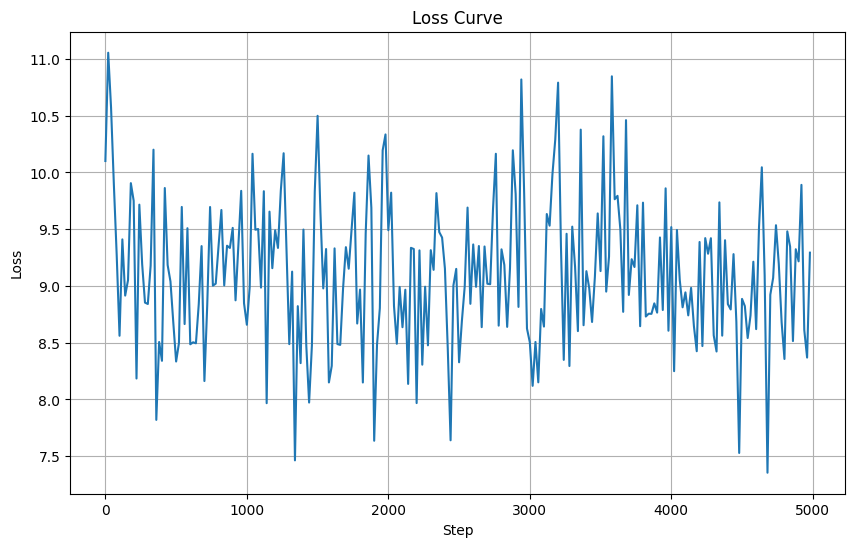

In [752]:
plot_loss(history)

Entrada: a - j
Saída: 6 - 23


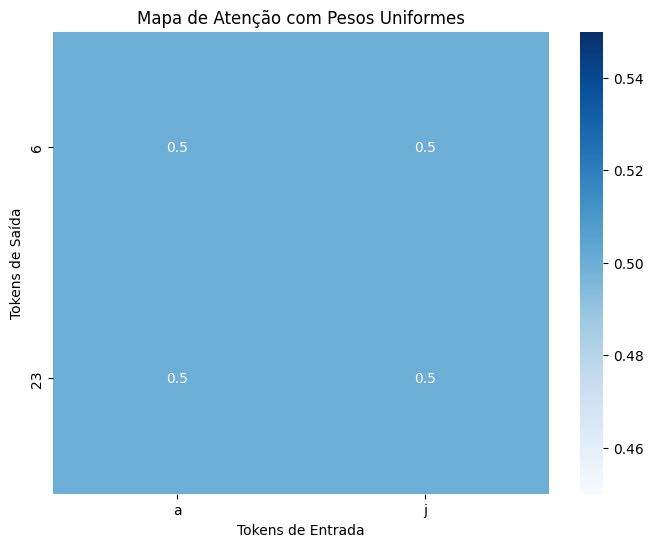

In [761]:
input = ["a", "j"]
inferencia(input)

##### Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)

In [762]:
# Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)
tokenizer = Tokenizer()

inputs = [
"a", "b", "c", "d", "e", "f"
]
outputs = [str(i+1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
print(f"len(tokenizer.tokens_special): {len(tokenizer.tokens_special)}")
print(f"tokenizer.len_vocab_input: {tokenizer.len_vocab_input}")

len(tokenizer.tokens_special): 3
tokenizer.len_vocab_input: 9


In [763]:
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000
MAX_STEPS = 2

model = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

In [764]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = train(model, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 8.7577
Epoch 250/5000, Loss: 7.8078
Epoch 500/5000, Loss: 7.9529
Epoch 750/5000, Loss: 7.6953
Epoch 1000/5000, Loss: 5.2876
Epoch 1250/5000, Loss: 5.3815
Epoch 1500/5000, Loss: 7.2908
Epoch 1750/5000, Loss: 5.1304
Epoch 2000/5000, Loss: 4.2649
Epoch 2250/5000, Loss: 7.4317
Epoch 2500/5000, Loss: 7.3844
Epoch 2750/5000, Loss: 2.7650
Epoch 3000/5000, Loss: 4.4773
Epoch 3250/5000, Loss: 5.0425
Epoch 3500/5000, Loss: 6.5623
Epoch 3750/5000, Loss: 6.5659
Epoch 4000/5000, Loss: 6.5073
Epoch 4250/5000, Loss: 4.2631
Epoch 4500/5000, Loss: 4.1470
Epoch 4750/5000, Loss: 2.7513


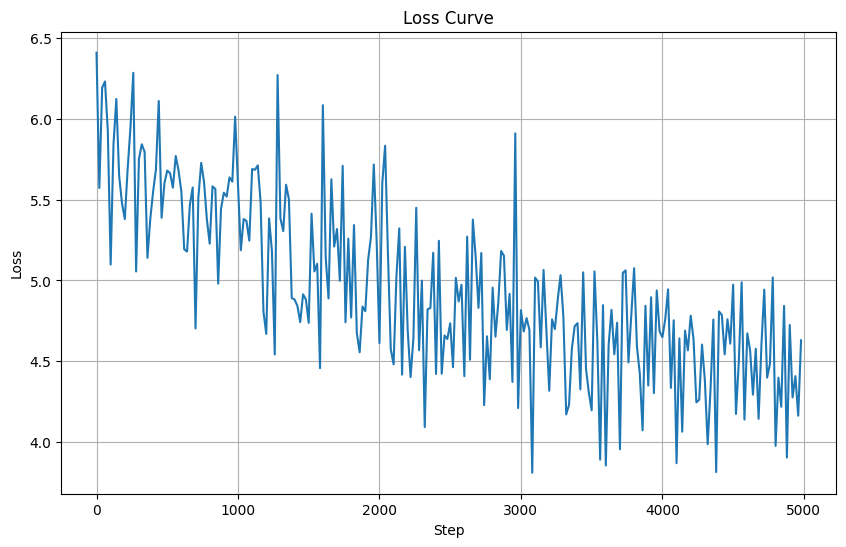

In [765]:
plot_loss(history)

Entrada: a - e
Saída: 1 - 5


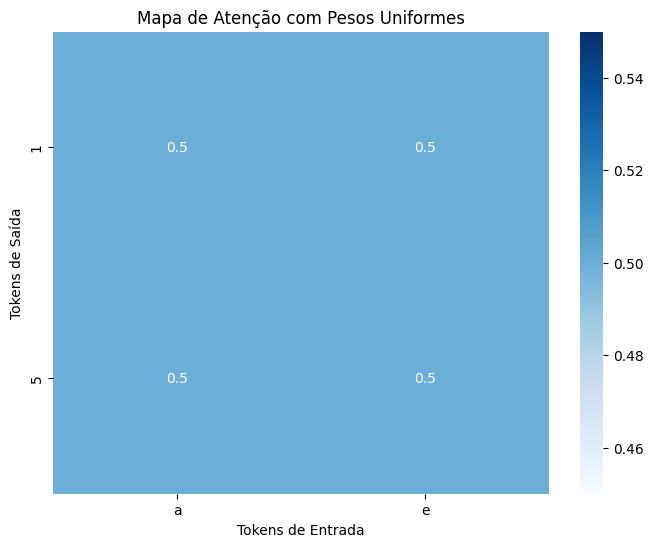

In [767]:
input = ["a", "e"]
inferencia(input)

#### **Questão 2**
Altere a classe que você criou na Questão 1 para que o Attention Output seja concatenado com o hidden state do decoder (e não com o embedding). Após isso, treine o modelo com o objetivo de traduzir cada letra para seu correspondente numérico:

- Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).

- Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)

- Após treinado, faça uma inferência condizente com o treinamento e plote o mapa de atenção para cada um dos modelos treinados.

> **Dica:** Não utilize a atenção implementada na classe Decoder, mas implemente o que for necessário na classe Seq2Seq.

In [768]:
class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.fc_out = nn.Linear(hidden_dim*2, output_vocab_size)
        self.encoder_hidden_states = None

    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None):
        if decoder_hidden_state is None:
            self.encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)

        # calcula avg attention dos hidden states do encoder
        self.attention = self.encoder_hidden_states.mean(dim=0).unsqueeze(0) # shape = (1, hidden_dim)

        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state)

        # Concatena o attention output com o hidden state do decoder
        output = torch.cat((output, self.attention ), dim=1)
        #output = torch.add(output, self.attention)

        output = self.fc_out(output)

        output_distribution = F.softmax(output, dim=1)

        return output_distribution, hidden

##### Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).

In [772]:
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000
MAX_STEPS = 2

# ##### Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).
tokenizer = Tokenizer()

inputs = [
"a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
"n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"
]
outputs = [str(i+1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

model = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

In [773]:
print(f"len(tokenizer.tokens_special): {len(tokenizer.tokens_special)}")
print(f"tokenizer.len_vocab_input: {tokenizer.len_vocab_input}")

len(tokenizer.tokens_special): 3
tokenizer.len_vocab_input: 29


In [774]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = train(model, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 13.4647
Epoch 250/5000, Loss: 5.8172
Epoch 500/5000, Loss: 9.2096
Epoch 750/5000, Loss: 12.6105
Epoch 1000/5000, Loss: 12.5981
Epoch 1250/5000, Loss: 5.8037
Epoch 1500/5000, Loss: 5.7093
Epoch 1750/5000, Loss: 5.7776
Epoch 2000/5000, Loss: 12.4926
Epoch 2250/5000, Loss: 12.6411
Epoch 2500/5000, Loss: 12.2514
Epoch 2750/5000, Loss: 7.4633
Epoch 3000/5000, Loss: 5.8224
Epoch 3250/5000, Loss: 4.9566
Epoch 3500/5000, Loss: 5.8157
Epoch 3750/5000, Loss: 5.8258
Epoch 4000/5000, Loss: 5.8282
Epoch 4250/5000, Loss: 12.0390
Epoch 4500/5000, Loss: 8.2796
Epoch 4750/5000, Loss: 5.8380


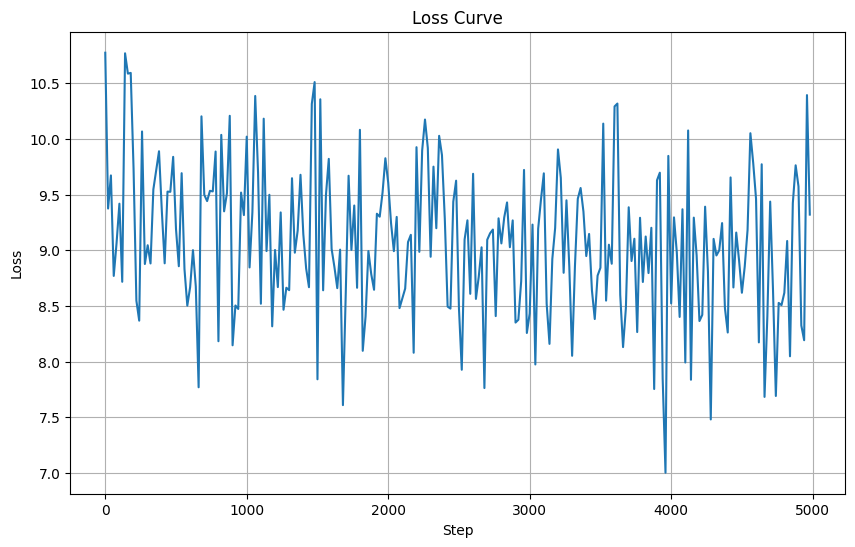

In [775]:
plot_loss(history)

Entrada: a - k
Saída: 4 - 16


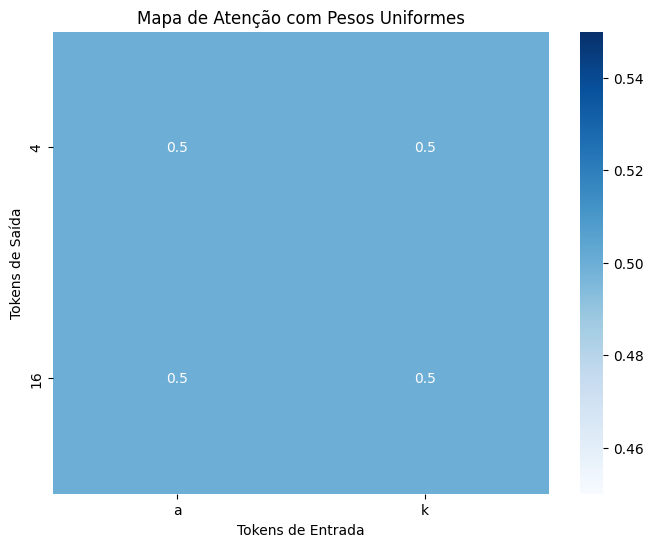

In [788]:
input = ["a", "k"]
inferencia(input)

##### Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)

In [801]:
# ##### Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)
tokenizer = Tokenizer()

inputs = [
"a", "b", "c", "d", "e", "f"
]
outputs = [str(i+1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000
MAX_STEPS = 2

model = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

In [802]:
print(f"len(tokenizer.tokens_special): {len(tokenizer.tokens_special)}")
print(f"tokenizer.len_vocab_input: {tokenizer.len_vocab_input}")

len(tokenizer.tokens_special): 3
tokenizer.len_vocab_input: 9


In [803]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = train(model, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 6.5368
Epoch 250/5000, Loss: 7.9982
Epoch 500/5000, Loss: 7.7103
Epoch 750/5000, Loss: 5.6689
Epoch 1000/5000, Loss: 5.9320
Epoch 1250/5000, Loss: 5.1338
Epoch 1500/5000, Loss: 3.6869
Epoch 1750/5000, Loss: 2.7711
Epoch 2000/5000, Loss: 7.4960
Epoch 2250/5000, Loss: 2.7630
Epoch 2500/5000, Loss: 4.2813
Epoch 2750/5000, Loss: 6.9194
Epoch 3000/5000, Loss: 4.2447
Epoch 3250/5000, Loss: 2.7493
Epoch 3500/5000, Loss: 2.7471
Epoch 3750/5000, Loss: 2.7471
Epoch 4000/5000, Loss: 2.7484
Epoch 4250/5000, Loss: 2.7459
Epoch 4500/5000, Loss: 4.1253
Epoch 4750/5000, Loss: 5.6174


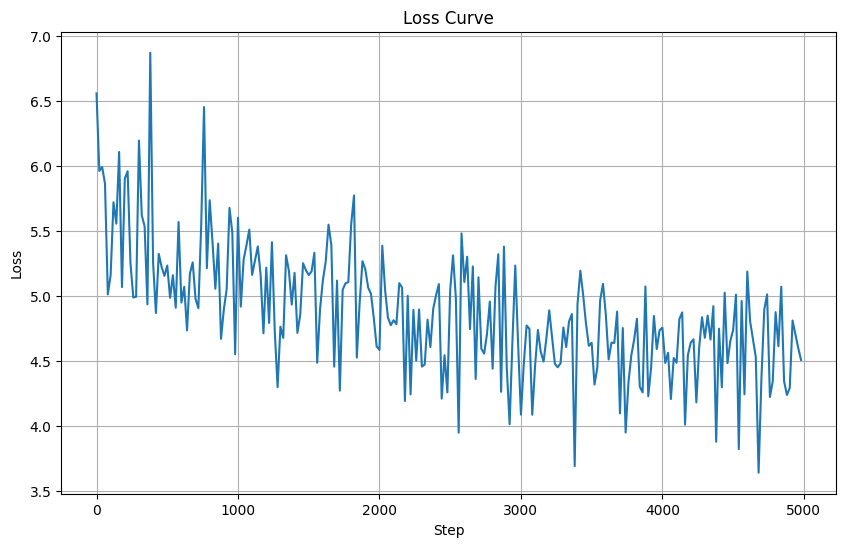

In [804]:
plot_loss(history)

Entrada: a - f
Saída: 1 - 6


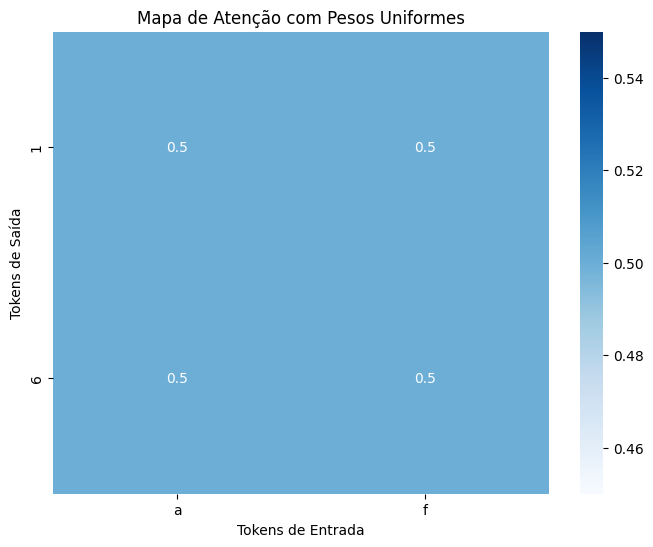

In [805]:
input = ["a", "f"]
inferencia(input)

#### **Questão 3**

Implemente o mecanismo de atenção de  Bahdanau et al. (2015). Após isso, treine dois o modelo com o objetivo de traduzir cada letra para seu correspondente numérico:
- Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).

- Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)

- Após treinado, faça uma inferência condizente com o treinamento e plote o mapa de atenção para cada um dos modelos treinados.

In [806]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(BahdanauAttention, self).__init__()
        self.hidden_dim = hidden_dim

    def forward(self, decoder_hidden_state, encoder_hidden_states):

        decoder_hidden_state = decoder_hidden_state.unsqueeze(0)
        attention_scores = torch.matmul(encoder_hidden_states, decoder_hidden_state.T).squeeze(-1)
        #attention_scores = torch.matmul(decoder_hidden_state, encoder_hidden_states.T).squeeze(-1)

        attention_weights = F.softmax(attention_scores, dim=0)

        attention_output = torch.sum(attention_weights.unsqueeze(1) * encoder_hidden_states, dim=0)
        attention_output = attention_output.unsqueeze(0)

        return attention_output, attention_weights

In [807]:
class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, use_attention=True)

        self.attention = BahdanauAttention(hidden_dim) #BahdanauAttention

        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)

    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None):
        if decoder_hidden_state is None:
            self.encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)

        self.attention_output, self.attention_weights = self.attention(decoder_hidden_state[-1], self.encoder_hidden_states)

        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state, self.attention_output)

        output = self.fc_out(output)

        output_distribution = F.softmax(output, dim=1)

        return output_distribution, hidden

##### Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).

In [851]:
# Agora, vamos configurar e utilizar nosso modelo
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000
MAX_STEPS = 3

# ##### Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).
tokenizer = Tokenizer()

inputs = [
"a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
"n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"
]
outputs = [str(i+1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

model = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

In [852]:
print(f"len(tokenizer.tokens_special): {len(tokenizer.tokens_special)}")
print(f"tokenizer.len_vocab_input: {tokenizer.len_vocab_input}")

len(tokenizer.tokens_special): 3
tokenizer.len_vocab_input: 29


In [853]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = train(model, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 10.1102
Epoch 250/5000, Loss: 5.8167
Epoch 500/5000, Loss: 5.7930
Epoch 750/5000, Loss: 9.1576
Epoch 1000/5000, Loss: 12.5849
Epoch 1250/5000, Loss: 5.7949
Epoch 1500/5000, Loss: 9.1540
Epoch 1750/5000, Loss: 5.6412
Epoch 2000/5000, Loss: 12.5147
Epoch 2250/5000, Loss: 9.2150
Epoch 2500/5000, Loss: 8.6112
Epoch 2750/5000, Loss: 8.4992
Epoch 3000/5000, Loss: 9.2035
Epoch 3250/5000, Loss: 5.1036
Epoch 3500/5000, Loss: 5.7426
Epoch 3750/5000, Loss: 5.8289
Epoch 4000/5000, Loss: 5.7380
Epoch 4250/5000, Loss: 5.8229
Epoch 4500/5000, Loss: 5.8275
Epoch 4750/5000, Loss: 5.8258


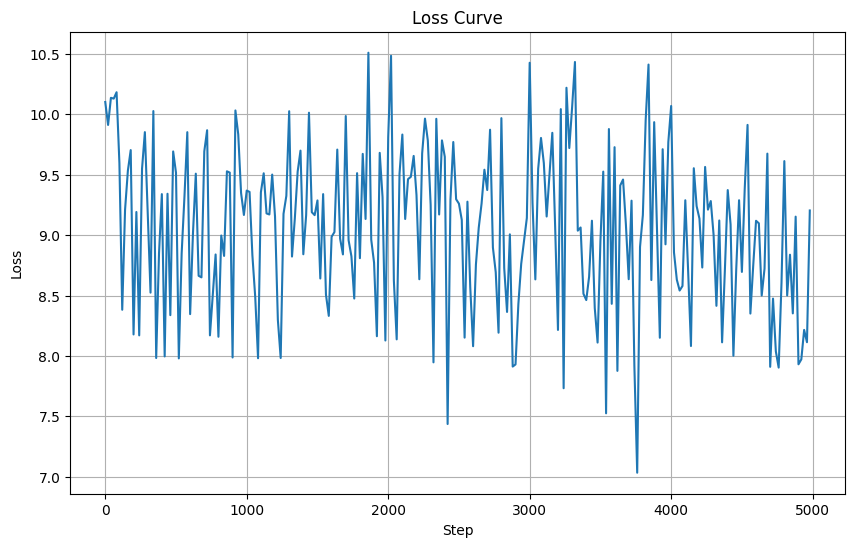

In [854]:
plot_loss(history)

In [855]:
def inferencia(input_tokens):

  #o modelo primeiro passa os tokens de entrada pelo codificador para obter os estados ocultos. Em seguida, começando com o token <sos>, calcula a atenção entre os hidden do decode
  #usa essa atenção para gerar o próximo token, att o hidden do decoder até que o token <eos> seja gerado. Os pesos de atenção coletados e é isso que ta sendo imprimido'''

    enc_inp = tokenizer.tokens2inputs_id(input_tokens)
    hidden_state = None
    token_id = torch.tensor([tokenizer.SOS_ID])
    outputs_ids = []
    attention_maps = []

    # codifica
    encoder_hidden_states, hidden_state = model.encoder(enc_inp)

    for i in range(MAX_STEPS):
        # calcula a atenção com o hidden atual do decoder
        attention_output, attention_weights = model.attention(hidden_state[-1], encoder_hidden_states)
        # decoder
        output, hidden_state = model.decoder(token_id, hidden_state, attention_output)

        output = model.fc_out(output)
        output_distribution = F.softmax(output, dim=1)

        #token predito
        token_id = torch.argmax(output_distribution, dim=1)
        outputs_ids.append(token_id.item())

        # pesos de atenção
        attention_maps.append(attention_weights.detach().cpu().numpy())

        if token_id.item() == tokenizer.EOS_ID:
            break

    input_tokens_display = input_tokens
    output_tokens_display = [tokenizer.outputs_id2text(id) for id in outputs_ids]

    # Converte a lista de mapas de atenção em uma matriz
    attention_matrix = np.vstack(attention_maps)  # Shape: (output_length, input_length)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention_matrix, annot=True, cmap='Blues',
                xticklabels=input_tokens_display, yticklabels=output_tokens_display)
    plt.xlabel('Tokens de Entrada')
    plt.ylabel('Tokens de Saída')
    plt.title('Mapa de Atenção')
    plt.show()

    print(f"Entrada: {' - '.join(input_tokens_display)}")
    print(f"Saída: {' - '.join(output_tokens_display)}")


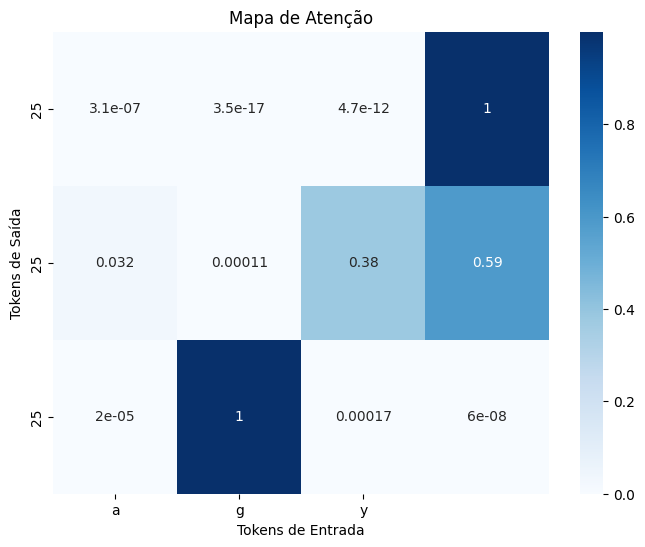

Entrada: a - g - y
Saída: 25 - 25 - 25


In [856]:
input = ["a", "g", "y"]
inferencia(input)

##### Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)

In [859]:
# Agora, vamos configurar e utilizar nosso modelo
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000
MAX_STEPS = 3

# ##### Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).
tokenizer = Tokenizer()

inputs = [
"a", "b", "c", "d", "e", "f"
]
outputs = [str(i+1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

model = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

In [860]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = train(model, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 6.5874
Epoch 250/5000, Loss: 5.8491
Epoch 500/5000, Loss: 3.4444
Epoch 750/5000, Loss: 4.5197
Epoch 1000/5000, Loss: 3.3456
Epoch 1250/5000, Loss: 5.1614
Epoch 1500/5000, Loss: 7.5632
Epoch 1750/5000, Loss: 7.6335
Epoch 2000/5000, Loss: 2.7986
Epoch 2250/5000, Loss: 2.7729
Epoch 2500/5000, Loss: 4.9695
Epoch 2750/5000, Loss: 7.2896
Epoch 3000/5000, Loss: 2.7556
Epoch 3250/5000, Loss: 6.0020
Epoch 3500/5000, Loss: 3.0905
Epoch 3750/5000, Loss: 2.7876
Epoch 4000/5000, Loss: 6.5394
Epoch 4250/5000, Loss: 5.6116
Epoch 4500/5000, Loss: 4.5089
Epoch 4750/5000, Loss: 4.2844


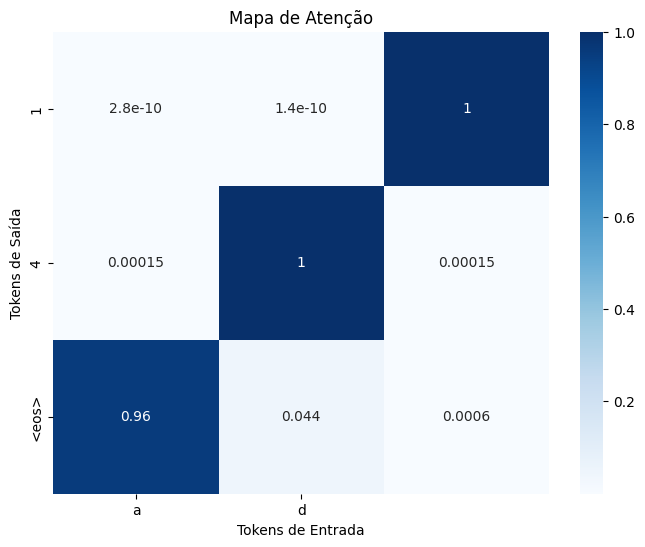

Entrada: a - d
Saída: 1 - 4 - <eos>


In [861]:
input = ["a", "d"]
inferencia(input)

#### **Questão 4**
Implemente a "??? Attention" apresentada durante a aula.  Após isso, treine dois modelos com o objetivo de traduzir cada letra para seu correspondente numérico:
- Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).

- Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)

- Após treinado, faça uma inferência condizente com o treinamento e plote o mapa de atenção para cada um dos modelos treinados.

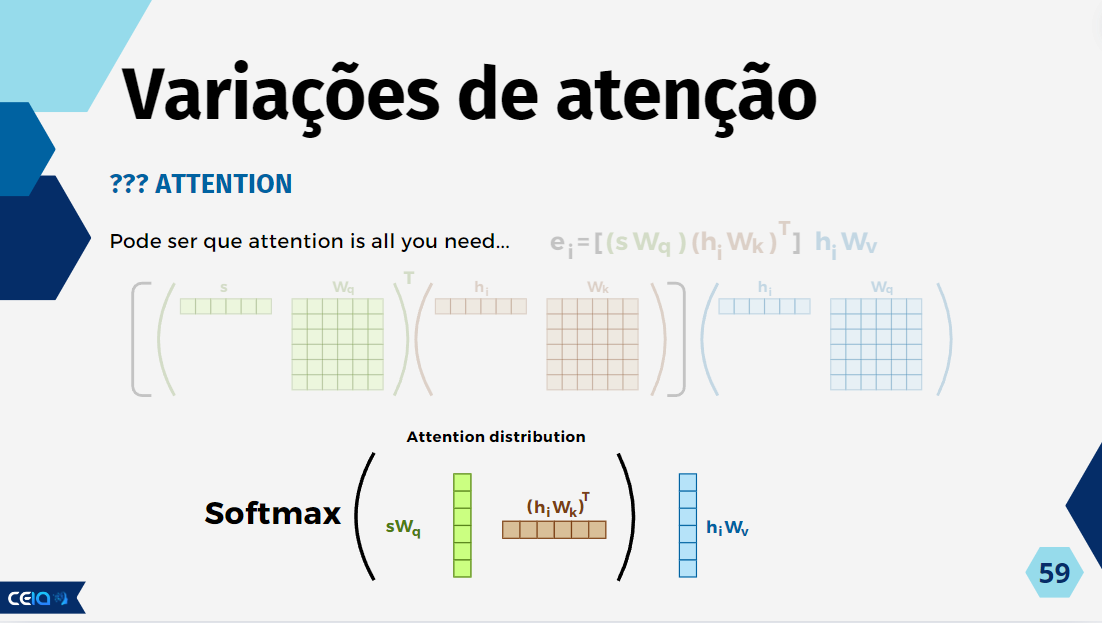

In [887]:
class WhatAttention(nn.Module):
    def __init__(self, hidden_size, embedd_dim):
        super(WhatAttention, self).__init__()
        self.query = nn.Linear(embedd_dim, hidden_size)
        self.key = nn.Linear(embedd_dim, hidden_size)
        self.value = nn.Linear(embedd_dim, hidden_size)
        self.softmax = nn.Softmax(dim=0)

    def forward(self, encoder_hidden_states, decoder_hidden_state):
        query = self.query(decoder_hidden_state)  # hidden_size
        values = self.value(encoder_hidden_states)  # seq_len, hidden_size
        keys = self.key(encoder_hidden_states)  # seq_len, hidden_size

        scores = torch.matmul(query, keys.T)

        attention_matrix = self.softmax(scores)# 1, seq_len
        attention_output = torch.matmul(attention_matrix, values).unsqueeze(0)# 1, hidden_size

        return attention_output, attention_matrix

In [891]:
class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, sos_id=0, eos_id=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, emb_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_vocab_size, emb_dim, hidden_dim, n_layers, dropout, use_attention=True)
        self.attention = WhatAttention(hidden_dim, emb_dim)
        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)
        self.encoder_hidden_states = None

    def forward(self, inputs_id_encoder=None, input_id_decoder=None, decoder_hidden_state=None):
        if decoder_hidden_state is None:
            self.encoder_hidden_states, decoder_hidden_state = self.encoder(inputs_id_encoder)

        attention_output, attention_matrix = self.attention(self.encoder_hidden_states, decoder_hidden_state[-1])

        output, hidden = self.decoder(input_id_decoder, decoder_hidden_state, attention=attention_output)

        output = self.fc_out(output)

        output_distribution = F.softmax(output, dim=1)

        return output_distribution, hidden

##### Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).

In [892]:
# Agora, vamos configurar e utilizar nosso modelo
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000
MAX_STEPS = 3

# ##### Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).
tokenizer = Tokenizer()

inputs = [
"a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m",
"n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"
]
outputs = [str(i+1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

model = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

In [893]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = train(model, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 13.4650
Epoch 250/5000, Loss: 9.1657
Epoch 500/5000, Loss: 5.8091
Epoch 750/5000, Loss: 12.5581
Epoch 1000/5000, Loss: 5.8107
Epoch 1250/5000, Loss: 5.8099
Epoch 1500/5000, Loss: 5.8037
Epoch 1750/5000, Loss: 9.1311
Epoch 2000/5000, Loss: 5.4331
Epoch 2250/5000, Loss: 5.1017
Epoch 2500/5000, Loss: 5.7929
Epoch 2750/5000, Loss: 8.3126
Epoch 3000/5000, Loss: 9.2164
Epoch 3250/5000, Loss: 8.9711
Epoch 3500/5000, Loss: 5.7780
Epoch 3750/5000, Loss: 5.8187
Epoch 4000/5000, Loss: 5.8203
Epoch 4250/5000, Loss: 8.3188
Epoch 4500/5000, Loss: 8.5245
Epoch 4750/5000, Loss: 9.1561


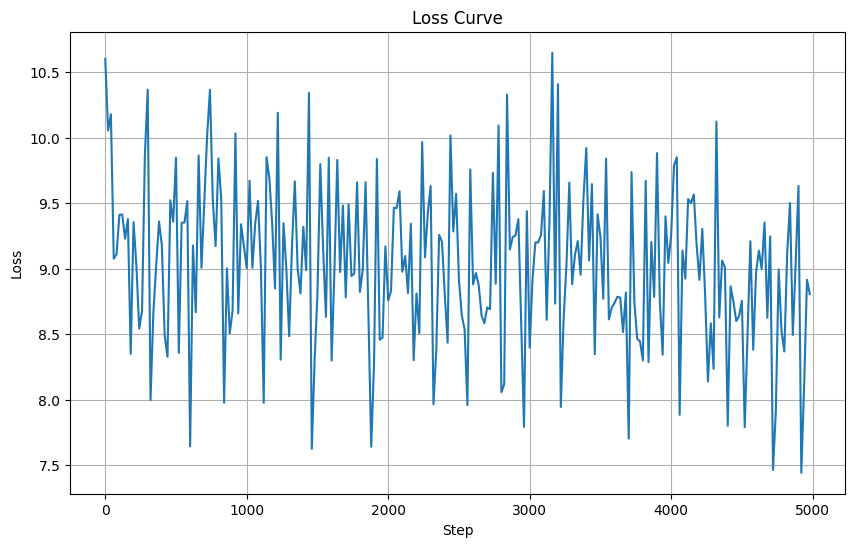

In [894]:
plot_loss(history)

##### Um modelo com o alfabeto até a letra f (a:1, b:2, c:3, ... f:6)

In [898]:
# Agora, vamos configurar e utilizar nosso modelo
input_vocab_size = tokenizer.len_vocab_input
output_vocab_size = tokenizer.len_vocab_output
emb_dim = 32
hidden_dim = 32
n_layers = 2
dropout = 0.2
learning_rate = 0.001
num_steps = 5000
MAX_STEPS = 3

# ##### Um modelo com o alfabeto completo (a:1, b:2, c:3, ..., z:26).
tokenizer = Tokenizer()

inputs = [
"a", "b", "c", "d", "e", "f"
]
outputs = [str(i+1) for i, _ in enumerate(inputs)]

tokenizer.add_input_vocab(inputs)
tokenizer.add_output_vocab(outputs)

model = Seq2Seq(input_vocab_size, output_vocab_size, emb_dim, hidden_dim, n_layers, dropout)

In [899]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = train(model, tokenizer, criterion, optimizer, num_steps)

Epoch 0/5000, Loss: 8.8703
Epoch 250/5000, Loss: 3.4398
Epoch 500/5000, Loss: 3.3854
Epoch 750/5000, Loss: 7.8014
Epoch 1000/5000, Loss: 5.0071
Epoch 1250/5000, Loss: 7.6360
Epoch 1500/5000, Loss: 5.1265
Epoch 1750/5000, Loss: 2.7680
Epoch 2000/5000, Loss: 7.4563
Epoch 2250/5000, Loss: 6.7665
Epoch 2500/5000, Loss: 2.9441
Epoch 2750/5000, Loss: 5.1763
Epoch 3000/5000, Loss: 6.9493
Epoch 3250/5000, Loss: 6.7170
Epoch 3500/5000, Loss: 3.6697
Epoch 3750/5000, Loss: 4.5771
Epoch 4000/5000, Loss: 2.7583
Epoch 4250/5000, Loss: 7.6810
Epoch 4500/5000, Loss: 2.7781
Epoch 4750/5000, Loss: 2.7584


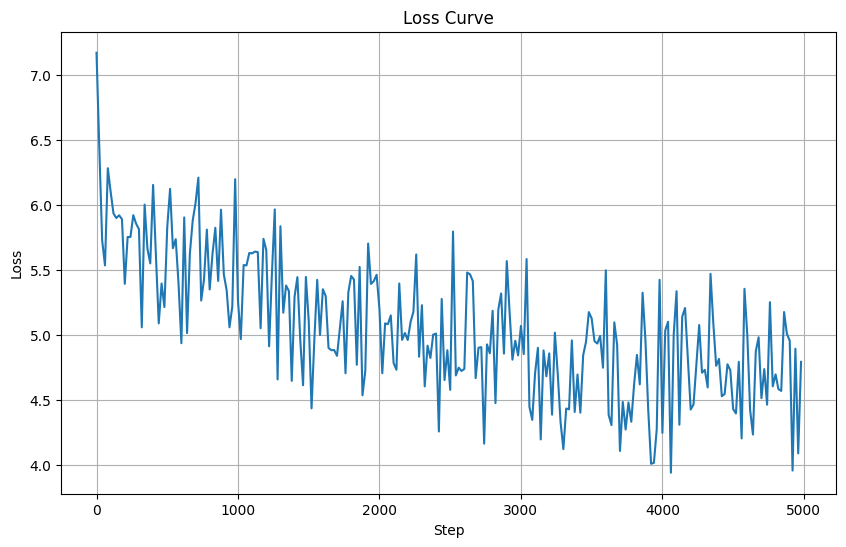

In [900]:
plot_loss(history)

#### **Questão 5**
A partir das suas descobertas nas Questões 3 e 4,  explore a criação de duas novas classes: "class BahdanauAttention" (com a atenção de Bahdanau) e "class WhatAttention" (com a ??? Attention). Após criá-las, adicione à classe Seq2Seq. Insira um novo parâmetro na classe Seq2Seq para permitir escolher qual attention deve-se utilizar (attention_implementation="bahdanau" para atenção de Bahdanau ou attention_implementation="qkv_attention" para ??? Attention)

> Dica: Observe a criação das classes Encoder e Decoder e como foram inseridas dentro da classe Seq2Seq

#### **Comentários finais**

- Relate aqui seus achados, dificuldades encontradas durante o processo, percepções sobre o tema, e demais comentários que gostaria de realizar.

Comentários:

>> Acho que poderia ser em grupo a atividade, afinal acabou que tivemos de fazer todos juntos e discutindo muito. Sao atividades que tomam um bom tempo. No fim fica um monte de gente desesperada pedindo codigo pra aqui e ali.

>> O nivel da pra sentir que eh bem elevado, mas que com certeza forca a aprender.

>> Como sugestao eu mandaria materiais de apoio como videos ou algo assim logo depois de postar a atividade.